# Secular evolution of the continental crust

This Jupyter notebook uses the <a href="https://github.com/brenhinkeller/StatGeochem.jl" target="_blank">StatGeochem</a> package to calculate and plot the geochemical evolution of igneous whole-rock geochemical compositions preserved in the extant continental crust, for any element or ratio included in the dataset of <a href="https://doi.org/10.1038/nature11024" target="_blank">Keller & Schoene 2012</a> and <a href="https://doi.org/10.1016/j.epsl.2017.10.031" target="_blank">2018</a>, using the weighted boostrap resampling algorithm therefrom, implemented in the <a href="https://julialang.org" target="_blank">Julia language</a>.

<a href="https://mybinder.org/v2/gh/brenhinkeller/StatGeochem.jl/master?filepath=examples%2Fplotmcvariable.ipynb" target="_blank"><img src="https://mybinder.org/badge_logo.svg" alt="Launch Binder notebook" align="left"></a> 
<p style="text-indent: 5px">If running this notebook as an online Binder notebook and the webpage times out, click the badge at left to relaunch (refreshing will not work). Note that any changes will be lost!</p>

Hint: `shift`-`enter` to run a single cell, or from the `Cell` menu select `Run All` to run the whole file. Any code from this notebook can be copied and pasted into the Julia REPL or a `.jl` script.
***
### Load required Julia packages

In [1]:
## --- Load (and install if neccesary) the StatGeochem package which has the resampling functions we'll want
try
    using StatGeochem
catch
    using Pkg
    Pkg.add(PackageSpec(url="https://github.com/brenhinkeller/StatGeochem.jl"))
    using StatGeochem
end

using Statistics, StatsBase, DelimitedFiles
using Plots; gr();

In [2]:
## --- Download and unzip the Keller and Schoene (2012) dataset
if ~isfile("ign.h5") # Unless it already exists
    download("https://storage.googleapis.com/statgeochem/ign.h5.gz","./ign.h5.gz")
    run(`gunzip -f ign.h5.gz`) # Unzip file
end

# Read HDF5 file
using HDF5
ign = h5read("ign.h5","vars") 

Dict{String,Any} with 117 entries:
  "Lower_Vp"   => [7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2, 7.2  …  7.2, 7.…
  "Pd"         => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.01, N…
  "MgO"        => [0.89, 0.5, 0.69, 2.83, 3.5, 2.81, 2.97, 2.32, 2.33, 1.74  … …
  "C"          => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, Na…
  "Nb"         => [3.5, 1.3, 3.4, 11.6, 10.4, 12.2, 11.5, 8.3, 7.0, 4.9  …  11.…
  "Ag"         => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.66, N…
  "Gd"         => [NaN, NaN, NaN, 7.99, 5.92, 6.12, 5.94, 5.46, 2.01, 2.7  …  N…
  "Middle_Rho" => [2.9, 2.9, 2.9, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8  …  2.9, 2.…
  "Age"        => [1.0, 1.0, 1.0, 1650.0, 1650.0, 1650.0, 1650.0, 1650.0, 1650.…
  "Sb"         => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, 1.…
  "TiO2"       => [0.27, 0.25, 0.24, 0.6, 0.63, 0.63, 0.59, 0.39, 0.48, 0.38  ……
  "Cs"         => [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  Na

In [3]:
## --- Compute proximity coefficients (inverse weights)

# # Calculate inverse weights based on spatiotemporal sample density
# k = invweight(ign["Latitude"], ign["Longitude"], ign["Age"])

# Since this is pretty computatually intensive, let's load a precomputed version instead
k = ign["k"]

# Probability of keeping a given data point when sampling
p = 1.0./((k.*median(5.0./k)) .+ 1.0); # Keep rougly one-fith of the data in each resampling

# Calculate age uncertainty
ign["Age_sigma"] = (ign["Age_Max"]-ign["Age_Min"])/2; 
t = (ign["Age_sigma"] .< 50) .| isnan.(ign["Age_sigma"]) # Find points with < 50 Ma absolute uncertainty
ign["Age_sigma"][t] .= 50; # Set 50 Ma minimum age uncertainty (1-sigma)

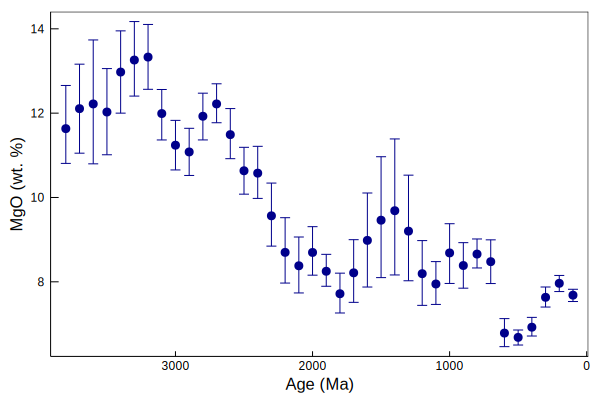

In [4]:
## --- Resample a single variable
tmin = 50 # Minimum age
tmax = 3850 # Maximum age
nbins = 38
elem = "MgO"

# Look only at samples in the basaltic silica range
t = 43 .< ign["SiO2"] .< 51 # Mafic

# Resample, returning binned means and uncertainties
# (c = bincenters, m = mean, el = lower 95% CI, eu = upper 95% CI)
(c,m,el,eu) = bin_bsr_means(ign["Age"][t], ign[elem][t], tmin,tmax,nbins, p=p[t], x_sigma=ign["Age_sigma"][t])

# Plot results
plot(c,m,yerror=(el,eu),seriestype=:scatter,color=:darkblue,markerstrokecolor=:auto,label="")
plot!(xlabel="Age (Ma)", ylabel="$elem (wt. %)",framestyle=:box,grid=:off,xflip=true) # Format plot

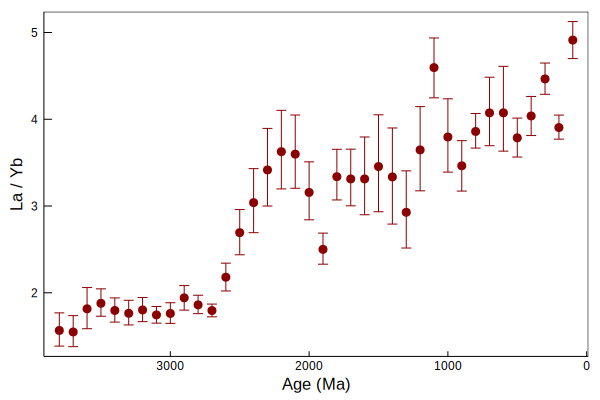

In [5]:
## ---  Resample a ratio
tmin = 50 # Minimum age
tmax = 3850 # Maximum age
nbins = 38
num = "La" # Numerator
denom = "Yb" # Denominator

# Look only at samples in the basaltic silica range
t = 43 .< ign["SiO2"] .< 51 # Mafic

# Exclude outliers
t = t .& inpctile(ign[num], 99) .& inpctile(ign[denom], 99)

# Resample, returning binned means and uncertainties 
# (c = bincenters, m = mean, el = lower 95% CI, eu = upper 95% CI)
(c,m,el,eu) = bin_bsr_ratios(ign["Age"][t], ign[num][t], ign[denom][t], tmin,tmax,nbins, p=p[t], x_sigma=ign["Age_sigma"][t], num_sigma=ign[num][t]*0.05, denom_sigma=ign[denom][t]*0.05)

# Plot results
h = plot(c,m,yerror=(el,eu),seriestype=:scatter,color=:darkred,markerstrokecolor=:auto,label="")
plot!(h, xlabel="Age (Ma)", ylabel="$(num) / $(denom)",framestyle=:box,grid=:off,xflip=true) # Format plot
display(h)

In [ ]:
## --- Ratio differentiation
xelem = "SiO2"
xmin = 40 # Minimum age
xmax = 80 # Maximum age
nbins = 20
num = "Sc" # Numerator
denom = "Yb" # Denominator

# Exclude outliers
t = inpctile(ign[num], 99) .& inpctile(ign[denom], 99)

# Resample, returning binned means and uncertainties
# (c = bincenters, m = mean, el = lower 95% CI, eu = upper 95% CI)
(c,m,el,eu) = bin_bsr_ratios(ign[xelem][t], ign[num][t], ign[denom][t], xmin,xmax,nbins, p=,p[t], x_sigma=ign[xelem][t]*0.01, num_sigma=ign[num][t]*0.05, denom_sigma=ign[denom][t]*0.05)

# Plot results
h = plot(c,m,yerror=(el,eu),seriestype=:scatter,color=:darkred,markerstrokecolor=:auto,label="")
plot!(h, xlabel=xelem, ylabel="$(num) / $(denom)",xlims=(xmin,xmax),framestyle=:box,grid=:off) # Format plot
display(h)
